In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import os
from PIL import Image
from tqdm.notebook import tqdm
from torch.nn.functional import relu
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
from SHG import SHG
from utils import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.base import clone
from sklearn_extra.cluster import KMedoids

In [2]:
""" PATHS """

# ALL SKELETONS
SHG_ALL_DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/train_all/"
SHG_AE_ALL_DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/SHG_AE/latent_space/all/"

# OBSERVATIONS WITH ONLY FULL SKELETONS
SHG_FULL_DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/train_full_skeleton/"
SHG_AE_FULL_DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/SHG_AE/latent_space/full/"

# SAVING PATH
Saving_path = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/"

In [3]:
""" DATASET AND DATALOADER """

class dataset(Dataset):
    def __init__(self, PATH):
        self.FULL_PATH = PATH
        self.listdir = os.listdir(self.FULL_PATH)

    def __len__(self):
        return len(self.listdir)

    def __getitem__(self, i):
        path = self.FULL_PATH + self.listdir[i]
        data = np.load(path)
        return data

SHG_AE_ALL_DATASET = dataset(SHG_AE_ALL_DATA_PATH)
SHG_AE_ALL_DATALOADER = DataLoader(SHG_AE_ALL_DATASET)

SHG_ALL_DATASET = dataset(SHG_ALL_DATA_PATH)
SHG_ALL_DATALOADER = DataLoader(SHG_ALL_DATASET)

SHG_AE_FULL_DATASET = dataset(SHG_AE_FULL_DATA_PATH)
SHG_AE_FULL_DATALOADER = DataLoader(SHG_AE_FULL_DATASET)

SHG_FULL_DATASET = dataset(SHG_FULL_DATA_PATH)
SHG_FULL_DATALOADER = DataLoader(SHG_FULL_DATASET)

In [4]:
""" CREATING DATASETS FOR PCA - ALL"""

N = 124040 # Number of observations
SHG_all_latent_space = []
SHG_AE_all_latent_space = []

# SHG
for i, x in enumerate(tqdm(SHG_ALL_DATALOADER, total = N - 1, desc = "SHG", leave = False)):
    SHG_all_latent_space.append(x.data.numpy())

    if (i == N - 1):
        break
SHG_all_latent_space = np.array(SHG_all_latent_space).reshape((N, -1))

# SHG_AE
for i, x in enumerate(tqdm(SHG_AE_ALL_DATALOADER, total = N - 1, desc = "SHG_AE", leave = False)):
    SHG_AE_all_latent_space.append(x.data.numpy())

    if (i == N - 1):
        break
SHG_AE_all_latent_space = np.array(SHG_AE_all_latent_space).reshape((N, -1))

SHG needs 541 principal components to reach 95% explained variance ratio
SHG_AE needs 16 principal components to reach 95% explained variance ratio


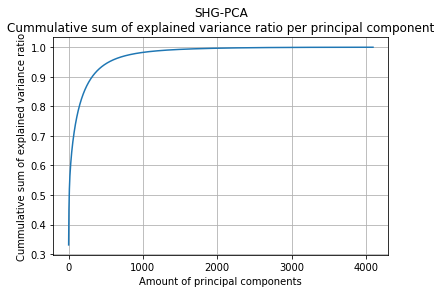

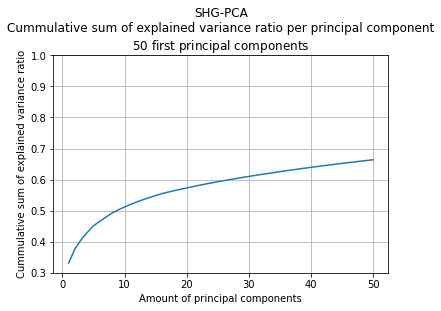

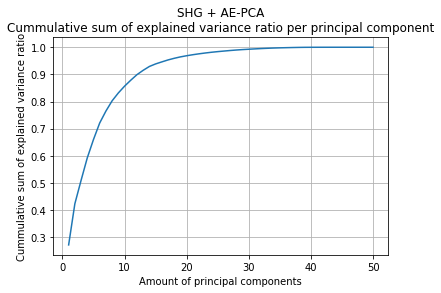

In [5]:
""" PCA - ALL """

# Fitting PCA's
SHG_all_pca = PCA(n_components = SHG_all_latent_space.shape[1]).fit(SHG_all_latent_space)
SHG_AE_all_pca = PCA(n_components = SHG_AE_all_latent_space.shape[1]).fit(SHG_AE_all_latent_space)

# Finding cum. sums of variances
SHG_all_cum_sum = np.cumsum(SHG_all_pca.explained_variance_ratio_)
SHG_AE_all_cum_sum = np.cumsum(SHG_AE_all_pca.explained_variance_ratio_)

# Index when cum. sums > 0.95
SHG_ALL_THRESHOLD = np.argmax(SHG_all_cum_sum > 0.95)
SHG_AE_ALL_THRESHOLD = np.argmax(SHG_AE_all_cum_sum > 0.95)

print("SHG needs {} principal components to reach 95% explained variance ratio".format(SHG_ALL_THRESHOLD))
print("SHG_AE needs {} principal components to reach 95% explained variance ratio".format(SHG_AE_ALL_THRESHOLD))

# Plotting variances
plt.figure()
plt.plot(np.arange(1, 4097, 1), SHG_all_cum_sum)
plt.title("SHG-PCA\nCummulative sum of explained variance ratio per principal component")
plt.xlabel("Amount of principal components")
plt.ylabel("Cummulative sum of explained variance ratio")
plt.grid()
plt.savefig(Saving_path + "SHG_pca_var_dist.png")
plt.show()

plt.figure()
plt.plot(np.arange(1, 51, 1), SHG_all_cum_sum[:50])
plt.yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.title("SHG-PCA\nCummulative sum of explained variance ratio per principal component\n$50$ first principal components")
plt.xlabel("Amount of principal components")
plt.ylabel("Cummulative sum of explained variance ratio")
plt.grid()
plt.savefig(Saving_path + "SHG_pca_var_dist_50.png")
plt.show()

plt.figure()
plt.plot(np.arange(1, 51, 1), SHG_AE_all_cum_sum)
plt.title("SHG + AE-PCA\nCummulative sum of explained variance ratio per principal component")
plt.xlabel("Amount of principal components")
plt.ylabel("Cummulative sum of explained variance ratio")
plt.grid()
plt.savefig(Saving_path + "SHG_AE_pca_var_dist.png")
plt.show()

In [6]:
""" CREATING DATASETS FOR PCA - FULL"""
SHG_full_latent_space = []
SHG_AE_full_latent_space = []

# SHG
for i, x in enumerate(tqdm(SHG_FULL_DATALOADER, desc = "SHG", leave = False)):
    SHG_full_latent_space.append(x.data.numpy())

SHG_full_latent_space = np.array(SHG_full_latent_space).reshape((len(SHG_FULL_DATALOADER), -1))

# SHG_AE
for i, x in enumerate(tqdm(SHG_AE_FULL_DATALOADER, desc = "SHG_AE", leave = False)):
    SHG_AE_full_latent_space.append(x.data.numpy())

SHG_AE_full_latent_space = np.array(SHG_AE_full_latent_space).reshape((len(SHG_FULL_DATALOADER), -1))

SHG needs 402 principal components to reach 95% explained variance ratio
SHG_AE needs 13 principal components to reach 95% explained variance ratio


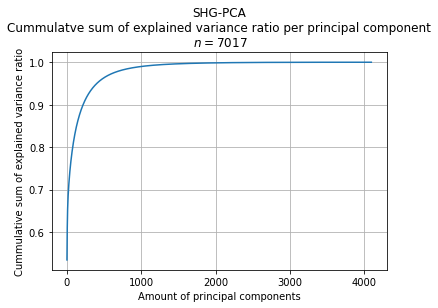

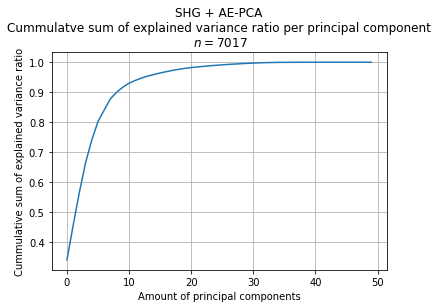

In [7]:
""" PCA - FULL """

# Fitting PCA's
SHG_full_pca = PCA(n_components = SHG_full_latent_space.shape[1]).fit(SHG_full_latent_space)
SHG_AE_full_pca = PCA(n_components = SHG_AE_full_latent_space.shape[1]).fit(SHG_AE_full_latent_space)

# Finding cum. sums of variances
SHG_full_cum_sum = np.cumsum(SHG_full_pca.explained_variance_ratio_)
SHG_AE_full_cum_sum = np.cumsum(SHG_AE_full_pca.explained_variance_ratio_)

# Index when cum. sums > 0.95
SHG_FULL_THRESHOLD = np.argmax(SHG_full_cum_sum > 0.95)
SHG_AE_FULL_THRESHOLD = np.argmax(SHG_AE_full_cum_sum > 0.95)

print("SHG needs {} principal components to reach 95% explained variance ratio".format(SHG_FULL_THRESHOLD))
print("SHG_AE needs {} principal components to reach 95% explained variance ratio".format(SHG_AE_FULL_THRESHOLD))

# Plotting variances
plt.figure()
plt.plot(SHG_full_cum_sum)
plt.title("SHG-PCA\nCummulatve sum of explained variance ratio per principal component\n $n = {}$".format(SHG_full_latent_space.shape[0]))
plt.xlabel("Amount of principal components")
plt.ylabel("Cummulative sum of explained variance ratio")
plt.grid()
plt.show()

plt.figure()
plt.plot(SHG_AE_full_cum_sum)
plt.title("SHG + AE-PCA\nCummulatve sum of explained variance ratio per principal component\n $n = {}$".format(SHG_AE_full_latent_space.shape[0]))
plt.xlabel("Amount of principal components")
plt.ylabel("Cummulative sum of explained variance ratio")
plt.grid()
plt.show()